## This is the start of our sign language detection project. Authors: Émilia and Arpan

In [6]:
labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']
img_size = 224
nb_classes = len(labels)

# Step 1: Importing Modules

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

import cv2
import os
import pickle
import numpy as np

# Loading dataset stored in onedrive:

In [ ]:
!wget https://downloads.rclone.org/v1.57.0/rclone-v1.57.0-linux-amd64.deb

!apt install ./rclone-v1.57.0-linux-amd64.deb



In [ ]:
!rclone config

In [ ]:
!mkdir -p /content/onedrive

!nohup rclone mount onedrive: /content/onedrive &

In [ ]:
root_path = "/content/onedrive/2022-2023/AI/archive.zip"
root_path_Train_nums = '/content/Train_Nums'
root_path_Test_nums = '/content/Test_Nums'
!unzip "/content/onedrive/2022-2023/AI/alphabet_ASL.zip"
!unzip "/content/onedrive/2022-2023/AI/archive.zip"
root_path_train_data = "/content/train_data"
root_path_test_data = "/content/test_data"
name_train_num_file = "Train_nums"
name_test_num_file = "Test_nums"
name_train_alph_file = "asl_alphabet_train"
name_test_alph_file = "asl_alphabet_test"

# Loading dataset stored in Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
#!unzip $root_path
!unzip '/content/gdrive/MyDrive/asl_alphabet_train.zip'
!unzip '/content/gdrive/MyDrive/asl_alphabet_test.zip'
root_path_train_data = '/content/asl_alphabet_train'
root_path_test_data = '/content/asl_alphabet_test'

# Step 2: Loading the data

In [ ]:
def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)
  
train_numbers = get_data(root_path_train_data)
test_numbers = get_data(root_path_test_data)

# Step 3: Visualize the data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '1')

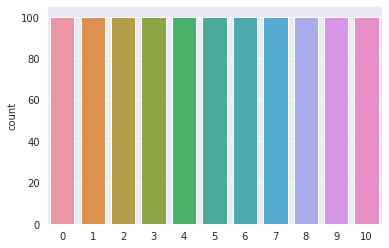

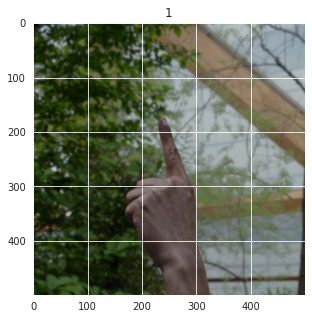

In [ ]:
#This block of code helps us visualize our dataset and see how many images of every label do we have
occurance = []
for img_number in train_numbers:
  occurance.append(img_number[1]) #this append the label of the image
sns.set_style('darkgrid')
sns.countplot(occurance)

#This is just fun because we can visualize images from the dataset if we need
plt.figure(figsize = (5,5))
plt.imshow(train_numbers[1][0]) #train_numbers[1][0] gives the jpeg file
plt.title(labels_numbers[train_numbers[0][1]]) #train_numbers[0][1] gives the label of the image

# Step 4: Data augmentation

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_generator = datagen.flow_from_directory(root_path_train_data, target_size=(224, 224), batch_size=50)

test_generator = datagen.flow_from_directory(root_path_test_data, target_size=(224,224), batch_size=50)

"""
train_datagen.fit_generator(train_generator)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory("/content/Test_Nums", target_size=(224,224))
test_datagen.fit_generator(test_generator)

"""

Found 96900 images belonging to 39 classes.
Found 1138 images belonging to 39 classes.


'\ntrain_datagen.fit_generator(train_generator)\ntest_datagen = ImageDataGenerator()\ntest_generator = test_datagen.flow_from_directory("/content/Test_Nums", target_size=(224,224))\ntest_datagen.fit_generator(test_generator)\n\n'

# Step 5: Defining our model

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(nb_classes, activation="softmax")) 

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history = model.fit(x_nb_train,y_nb_train,epochs = 500 , validation_data = (x_nb_val, y_nb_val))


In [6]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_size,img_size,3),
                   pooling='max',classes=nb_classes,
                   weights="imagenet")

'''
pretrained_model = tf.keras.applications.VGG19(
                  include_top=False,
                  weights=None,
                  input_tensor=None,
                  input_shape=None,
                  pooling='max',
                  classes=nb_classes,
                  classifier_activation="softmax")
'''


#for layer in pretrained_model.layers:
#        layer.trainable=False


resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(nb_classes, activation='softmax'))

resnet_model.summary()

resnet_model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


history = resnet_model.fit_generator(train_generator, validation_data=test_generator, epochs=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 39)                20007     
                                                                 
Total params: 24,656,807
Trainable params: 24,603,687
Non-trainable params: 53,120
_________________________________________________________________


<ipython-input-6-84d3dadf3f0b>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_model.fit_generator(train_generator, validation_data=test_generator, epochs=1)


  33/1938 [..............................] - ETA: 22:22:28 - loss: 6.5696 - accuracy: 0.1776

KeyboardInterrupt: ignored

# Saving the model

In [ ]:
with open('model_history', 'wb') as history_file:
    pickle.dump(history.history, history_file)

resnet_model.save("Model_number_only_2_epoch")

# Step 6: Visualizing our results

In [ ]:

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(6)

# plt.figure(figsize=(15, 15))
# # plt.subplot(2, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

predictions = resnet_model.predict_generator(test_generator)
print(len(predictions))
print(len(y_nb_train))
predictions = predictions.reshape(1,-1)[0]
# print(classification_report(y_nb_train, predictions, target_names = labels_numbers))

# Code to take photo through the webcam:

<IPython.core.display.Javascript object>

Saved to photo.jpg


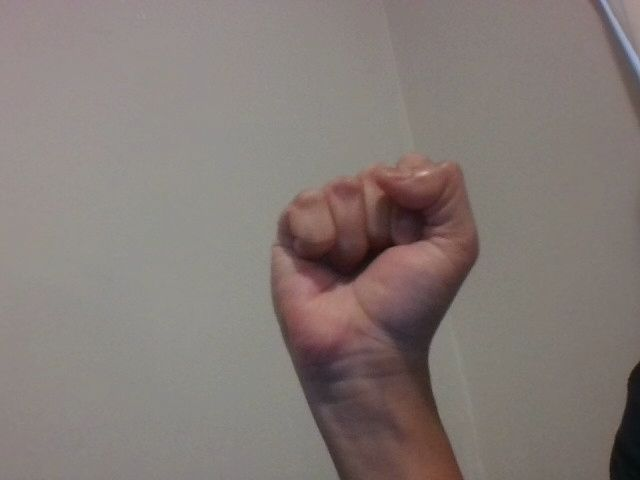

In [16]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
  
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Step 7: Testing our results

In [ ]:
#Loading our saved model
model = load_model('/content/gdrive/MyDrive/Model_2_epoch')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [20]:
img = tf.keras.utils.load_img('photo.jpg')
# plt.figure(figsize = (5,5))
# plt.imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())

predictions = model.predict(processed_image)
# print(predictions)

# classes_x=np.argmax(predictions,axis=1)
# print(classes_x)

max = np.argmax(predictions)
index_to_letter_map = {i: x for i, x in enumerate(labels)}
letter = index_to_letter_map[max]
print(f'The prdicted image is: {letter}')

1/1 [==============================] - 1s 1s/step
[[1.1312960e-05 1.4638795e-02 1.7366002e-06 8.8562984e-03 1.0647619e-03
  4.8839889e-04 1.8376909e-08 7.5684348e-04 1.3500397e-07 2.1321726e-05
  9.6116889e-01 8.4862239e-07 2.4945473e-03 1.4473056e-05 2.8697797e-10
  9.5727649e-03 1.0939438e-04 2.0444734e-04 2.0960177e-05 1.1413721e-05
  7.2501979e-07 8.2172711e-08 1.6949205e-07 6.4997985e-05 9.5307340e-05
  2.4128549e-06 3.4929794e-06 3.8978243e-09 1.2513428e-06 9.6827362e-06
  1.4910246e-04 1.3010558e-09 8.9775511e-09 8.1153267e-08 8.0502314e-06
  3.0683040e-08 6.9711941e-06 1.4419224e-04 7.6173332e-05]]
The prdicted image is: A


In [19]:
from PIL import Image

def preprocess_image(img, best_model):
    labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']
    # img_size = 224
    # img = tf.keras.utils.load_img(image)
    # # plt.figure(figsize = (5,5))
    # # plt.imshow(img)

    # image = tf.keras.utils.img_to_array(img)
    
    # image = tf.reshape(image, [image.shape[0], image.shape[1], 1])
    # image = image/255
    # image = tf.image.resize(image, [28, 28], preserve_aspect_ratio=True)
    
    # preprocessed_image = np.ones((1, 28, 28, 1))
    # preprocessed_image[0, :image.shape[0], :image.shape[1], :] = image


    # processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())
    
    img = tf.keras.utils.load_img('photo.jpg')
    img = img.resize((224,224))
    img_array = tf.keras.utils.img_to_array(img)


    img_batch = np.expand_dims(img_array, axis=0)

    processed_image = tf.keras.applications.resnet50.preprocess_input(img_batch)
    predictions = best_model.predict(processed_image)

    max = np.argmax(predictions)
    index_to_letter_map = {i: x for i, x in enumerate(labels)}
    letter = index_to_letter_map[max]

    return letter

image = Image.open('photo.jpg').convert('L')
    
letter = preprocess_image(image, model)
print(f'The image is predicted as {letter}')

1/1 [==============================] - 0s 222ms/step
The image is predicted as 10
